# Introduction

The original study explores using Graphene tattoos to measure bioimpendance, which the authors use to calculate blood pressure with high accuracy. My approach is to combine their feature sets, use AutoML (PyCaret) to select a model, and explore ways to boost the selected model's performance.

# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/TAMU-ESP/Graphene_BP.git

Cloning into 'Graphene_BP'...
Updating files:  36% (4/11)
Updating files:  45% (5/11)
Updating files:  54% (6/11)
Updating files:  63% (7/11)
Updating files:  72% (8/11)
Updating files:  81% (9/11)
Updating files:  90% (10/11)
Updating files: 100% (11/11)
Updating files: 100% (11/11), done.


# Data Exploration

Working from the files available on GitHub (GH), the goal of the data explorations was to identify any issues, resolve them, and finally combine the files.  

## Sensor Data

These initial DataFrames and plot show the impedence data for one of the trails. Eventhough the main approach focuses on the authors GH files, it's helpful to visualize the raw data as it shows the time series nature of the problem and is the ultimate source of the GH files feature set.

In [ ]:
# Import raw sensor data
bioz = pd.read_csv('data/data_trial03_bioz.csv')
fBP = pd.read_csv('data/data_trial03_finapresBP.csv')
fPPG = pd.read_csv('data/data_trial03_finapresPPG.csv')
PPG = pd.read_csv('data/data_trial03_ppg.csv')

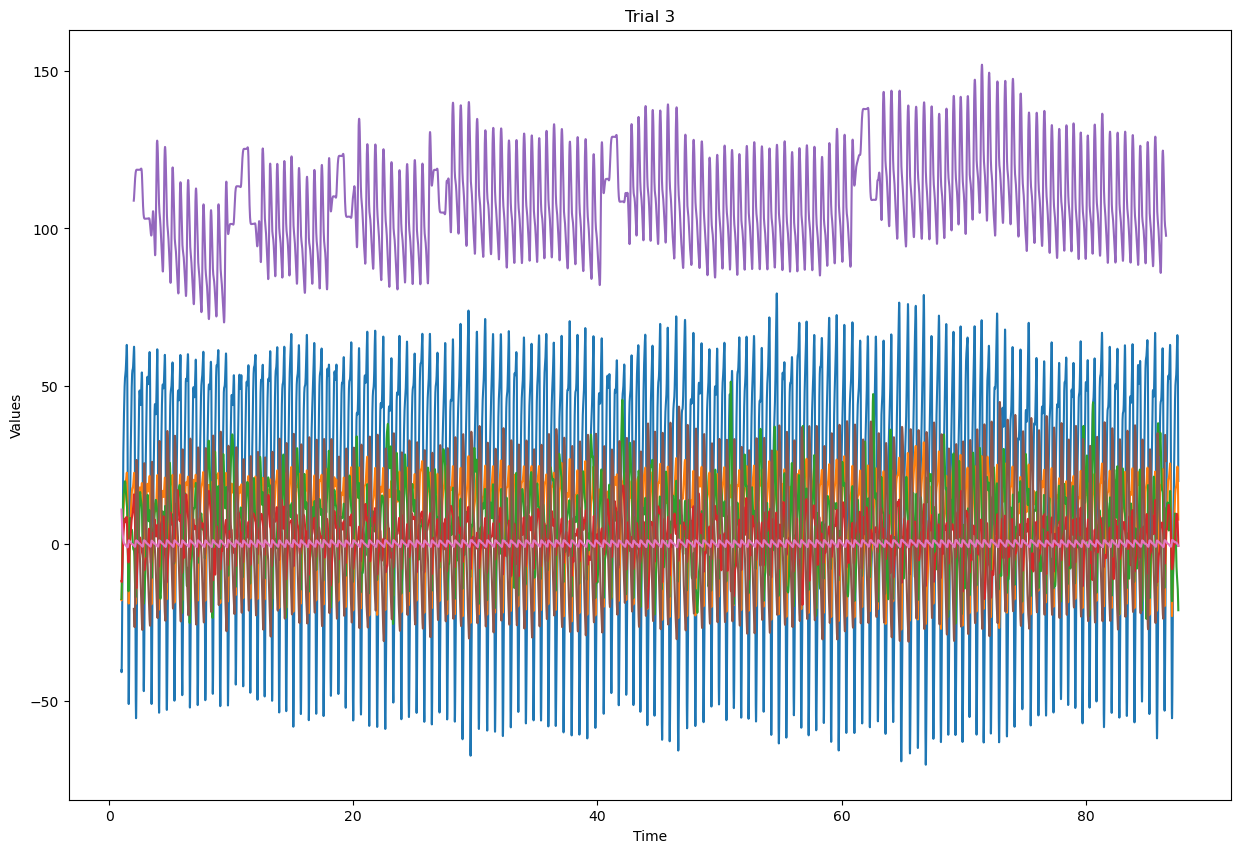

In [ ]:
# Create a figure and axis object (Claude AI Sonnet)
fig, ax = plt.subplots(figsize=(15, 10))

# Iterate over the DataFrames
for df in [bioz, fBP, fPPG, PPG]:
    # Plot each column (except 'time') against the 'time' column
    for col in df.columns[df.columns != 'time']:
        ax.plot(df['time'], df[col], label=f"{col} ({df[col]})")

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Values')
ax.set_title('Trial 3')

# Add a legend
ax.legend()

# Adjust the layout and display the plot
# plt.tight_layout()
plt.show()

## Processed Data

In [ ]:
# Import the processed data read for model input
dir = r"Graphene_BP/Data/features/2020-11-05"
ten_all = pd.read_csv(os.path.join(dir, 'f2_ma10_mn1_cn1_all.csv'))
ten_mean = pd.read_csv(os.path.join(dir, 'f2_ma10_mn1_cn1_mean_all.csv'))
twenty_all = pd.read_csv(os.path.join(dir, 'f2_ma20_mn1_all.csv'))
twenty_mean = pd.read_csv(os.path.join(dir, 'f2_ma20_mn1_mean_all.csv'))

In [ ]:
# Count rows as an indicator of merge eligibility
dfs = {'ten_all': ten_all,
       'ten_mean': ten_mean,
       'twenty_all': twenty_all,
       'twenty_mean': twenty_mean}
for name in dfs:
    print(name, ' :', dfs[name].count()[0])

ten_all  : 29809
ten_mean  : 29809
twenty_all  : 29809
twenty_mean  : 29809


In [ ]:
# Column counts
for name in dfs:
    print(name, ': ', len(dfs[name].columns))

In [ ]:
# View dimension columns
dims = ten_all.columns.tolist()[:4]
ten_all[dims]

,Sample,subject_id,setup_n,trial_n
0,1,1,1,1
1,2,1,1,1
2,3,1,1,1
3,4,1,1,1
4,5,1,1,1
...,...,...,...,...
29804,1992,1,3,14
29805,1993,1,3,14
29806,1994,1,3,14
29807,1995,1,3,14


In [ ]:
# View the data
dfs[list(dfs.keys())[0]]

,Sample,subject_id,setup_n,trial_n,fc,B1_MS__T,B2_MS__T,B3_MS__T,B4_MS__T,PPG_MS__T,...,P_D2D__IPA,P_D2M__IPAR,P_D2S__IPAR,P_D2I__IPAR,DBP,SBP,setup_name,exp_name,Sample_c,exp_setup_name
0,1,1,1,1,9375,1.362176,1.360896,1.350357,1.374123,1.400405,...,21.125804,0.075600,0.350191,0.964550,77.150605,120.531853,setup01_baseline,subject1_day1,1,subject1_day1_setup01_baseline
1,2,1,1,1,9375,2.039125,2.038059,2.022869,44.407641,2.075989,...,22.057734,0.074614,0.346211,0.955513,76.467119,121.353248,setup01_baseline,subject1_day1,2,subject1_day1_setup01_baseline
2,3,1,1,1,9375,2.698155,2.696491,2.683776,2.692992,2.734208,...,22.677360,0.073067,0.336330,0.941976,76.822703,122.553652,setup01_baseline,subject1_day1,3,subject1_day1_setup01_baseline
3,4,1,1,1,9375,3.346560,3.344512,3.336363,3.336192,3.381205,...,19.052404,0.079666,0.362136,0.994654,77.719712,120.973820,setup01_baseline,subject1_day1,4,subject1_day1_setup01_baseline
4,5,1,1,1,9375,3.966464,3.965227,3.948117,44.407641,4.001707,...,20.579856,0.077619,0.353275,0.935495,78.902194,120.850108,setup01_baseline,subject1_day1,5,subject1_day1_setup01_baseline
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29804,1992,1,3,14,9375,84.028971,84.031616,84.012544,48.203017,84.071253,...,12.323505,0.128618,0.407596,0.978555,78.578980,126.779706,setup03_valsalva,subject1_day4,7822,subject1_day4_setup03_valsalva
29805,1993,1,3,14,9375,84.642219,84.637995,84.635691,48.203017,84.685312,...,9.000323,0.118125,0.453181,0.950402,76.598455,127.226945,setup03_valsalva,subject1_day4,7823,subject1_day4_setup03_valsalva
29806,1994,1,3,14,9375,85.283584,85.280512,42.889860,85.273728,85.323989,...,15.393642,0.203967,0.447446,0.949446,74.924877,123.889615,setup03_valsalva,subject1_day4,7824,subject1_day4_setup03_valsalva
29807,1995,1,3,14,9375,85.918933,85.914752,42.889860,48.203017,85.962283,...,12.130614,0.186940,0.460745,0.964781,74.088953,121.692170,setup03_valsalva,subject1_day4,7825,subject1_day4_setup03_valsalva


In [ ]:
# Check for duplicates
ten_all['Duplicated'] = ten_all.duplicated(subset=dims, keep=False)
ten_slim = ten_all[dims + ['Duplicated']]
ten_slim[ten_slim['Duplicated'] == True]
# The first four examples are duplicates; I would expect only two examples if one of the dfs had a matching values. Time to check the ten df's for dups.

,Sample,subject_id,setup_n,trial_n,Duplicated
0,1,1,1,1,True
1,1,1,1,1,True
2,1,1,1,1,True
3,1,1,1,1,True
4,2,1,1,1,True
...,...,...,...,...,...
1920,904,1,2,7,True
1921,905,1,2,7,True
1922,905,1,2,7,True
1923,905,1,2,7,True


In [ ]:
# Slow version todo refactor
# remove duplicates
for name in dfs:
    dfs[name].drop_duplicates(subset=dims, keep='first', inplace=True)
    print(name, ' :', dfs[name].count()[0])

ten_all  : 29469
ten_mean  : 29469
twenty_all  : 29469
twenty_mean  : 29469


In [ ]:
# Test merge
# from functools import reduce
# master = reduce(lambda left,right: pd.merge(left,right, on=dims, how='inner'), list(dfs.values()))

In [ ]:
# merge
ten = pd.merge(ten_all, ten_mean, on=dims, how='inner', suffixes=('_all', '_mean'))
twenty = pd.merge(twenty_all, twenty_mean, on=dims, how='inner', suffixes=('_all', '_mean'))
master = pd.merge(ten, twenty, on=dims, how='inner', suffixes=('_ten', '_twenty'))
# for name in dfs:
#     print(name,' :',dfs[name].count()[0])
print('ten rows: ', ten.count()[0])
print('twenty rows: ', twenty.count()[0])
print('master rows: ', master.count()[0])

ten rows:  29469
twenty rows:  29469
master rows:  29469


In [ ]:
m_cols = (master.columns.tolist())
for col in m_cols:
    if not 'all' in col and not 'mean' in col:
        print(col)
print(m_cols)

Sample
subject_id
setup_n
trial_n
['Sample', 'subject_id', 'setup_n', 'trial_n', 'fc_all', 'B1_MS__T_all', 'B2_MS__T_all', 'B3_MS__T_all', 'B4_MS__T_all', 'PPG_MS__T_all', 'BR1_MS__A_all', 'BR2_MS__A_all', 'BR3_MS__A_all', 'BR4_MS__A_all', 'BI1_MS__A_all', 'BI2_MS__A_all', 'BI3_MS__A_all', 'BI4_MS__A_all', 'BI1_D2S__A_all', 'BI2_D2S__A_all', 'BI3_D2S__A_all', 'BI4_D2S__A_all', 'PPG_MS__IBI_all', 'B1_MS__IBI_all', 'B2_MS__IBI_all', 'B3_MS__IBI_all', 'B4_MS__IBI_all', 'B1_B2_MS__PTT_all', 'B1_B3_MS__PTT_all', 'B1_B4_MS__PTT_all', 'B2_B3_MS__PTT_all', 'B2_B4_MS__PTT_all', 'B3_B4_MS__PTT_all', 'B1_D2M__TR_all', 'B2_D2M__TR_all', 'B3_D2M__TR_all', 'B4_D2M__TR_all', 'B1_D2S__TR_all', 'B2_D2S__TR_all', 'B3_D2S__TR_all', 'B4_D2S__TR_all', 'B1_D2I__TR_all', 'B2_D2I__TR_all', 'B3_D2I__TR_all', 'B4_D2I__TR_all', 'B1_D2S__A_all', 'B2_D2S__A_all', 'B3_D2S__A_all', 'B4_D2S__A_all', 'B1_D2M__AR_all', 'B2_D2M__AR_all', 'B3_D2M__AR_all', 'B4_D2M__AR_all', 'B1_D2I__AR_all', 'B2_D2I__AR_all', 'B3_D2I__AR

In [ ]:
# DPB, SPB
dbp_targets = [col for col in m_cols if 'DBP' in col]
sbp_targets = [col for col in m_cols if 'SBP' in col]
targets = sbp_targets + dbp_targets
targets

['SBP_all_ten',
 'SBP_mean_ten',
 'SBP_all_twenty',
 'SBP_mean_twenty',
 'DBP_all_ten',
 'DBP_mean_ten',
 'DBP_all_twenty',
 'DBP_mean_twenty']

In [ ]:
master[dims + targets]

,Sample,subject_id,setup_n,trial_n,SBP_all_ten,SBP_mean_ten,SBP_all_twenty,SBP_mean_twenty,DBP_all_ten,DBP_mean_ten,DBP_all_twenty,DBP_mean_twenty
0,1,1,1,1,120.531853,121.252536,120.531853,124.510658,77.150605,77.412467,77.150605,80.235675
1,2,1,1,1,121.353248,121.730967,121.353248,125.082599,76.467119,78.000746,76.467119,80.419392
2,3,1,1,1,122.553652,122.727502,122.553652,125.202553,76.822703,78.655785,76.822703,80.328564
3,4,1,1,1,120.973820,123.567203,120.973820,124.904333,77.719712,79.453249,77.719712,80.210777
4,5,1,1,1,120.850108,124.091698,120.850108,124.622422,78.902194,79.827587,78.902194,80.148662
...,...,...,...,...,...,...,...,...,...,...,...,...
29464,1992,1,3,14,126.779706,125.128752,126.779706,124.292679,78.578980,76.685107,78.578980,76.104508
29465,1993,1,3,14,127.226945,125.250680,127.226945,124.585013,76.598455,76.621929,76.598455,76.278782
29466,1994,1,3,14,123.889615,125.123432,123.889615,124.736541,74.924877,76.444319,74.924877,76.400433
29467,1995,1,3,14,121.692170,124.710884,121.692170,124.706665,74.088953,76.232219,74.088953,76.514508


Choosing Targets from 'all' files because the ten and twenty correspond and the other being 'mean' may be aggregated.

In [ ]:
# drop SBP/DBP from other files
target_cols = ['SBP_all_ten', 'DBP_all_ten']
drop_columns = [i for i in targets if i not in target_cols]
setup_cols = master.select_dtypes('object').columns.tolist()
drop_columns = drop_columns + setup_cols
master = master.drop(drop_columns, axis=1)

In [39]:
# Check for duplicate columns (Claude Sonnet)
duplicated_cols = master.columns[master.T.duplicated(keep='first')].tolist()
# duplicated_cols.sort()
# master[duplicated_cols].T.sort_values(by=0)
# type(duplicated_cols.tolist())
# Drop the duplicated columns
master = master.drop(duplicated_cols, axis=1)

In [43]:
# checkpoint
# import os
# print(os.getcwd())
master.to_csv('master.csv',index=False)

# AutoML Baseline

My initial plan was to use PyCaret to identify the best performing model. Unfortunately, the compare model functionality was never able to fully process the data. It would essentially freeze at a consistent point. I removed the models where the process was frequently getting stuck. However, it did not remedy the situation.

Based on the partial model comparison, I selected

In [4]:
import os
os.chdir('/content/drive/MyDrive/Adv. Machine Learning/Assignment 3')
master = pd.read_csv('master.csv')

In [5]:
!pip install -q pycaret

In [32]:
filtered_master = master[(master['subject_id'] == 1) & (master['setup_n'] == 1)]

In [38]:
from pycaret.regression import *

s = setup(filtered_master, target='SBP_all_ten', train_size=0.9 session_id=123, data_split_shuffle=False)
# todo consider adding experiment tracking thru MLflow or wandb

,Description,Value
0,Session id,123
1,Target,SBP_all_ten
2,Target type,Regression
3,Original data shape,"(744, 280)"
4,Transformed data shape,"(744, 280)"
5,Transformed train set shape,"(520, 280)"
6,Transformed test set shape,"(224, 280)"
7,Numeric features,279
8,Rows with missing values,99.9%
9,Preprocess,True


In [ ]:
# remove least angle regression and linear regression because they slow down the processing
reg_models = models().index.tolist()
reg_models.remove('lar')
rm_len = round(len(reg_models))
rm1 = reg_models[:rm_len]
rm2 = reg_models[rm_len:]
reg_models == rm1 + rm2

In [ ]:
# functional API
best1 = compare_models(include=rm1)

In [51]:
# functional API
best2 = compare_models(include=rm2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.8529,5.7701,2.3294,0.7495,0.0166,0.0133,0.1320
ridge,Ridge Regression,2.1499,7.3079,2.6696,0.6792,0.0192,0.0157,0.0830
gbr,Gradient Boosting Regressor,2.3912,9.8418,2.9452,0.6411,0.0214,0.0176,3.3020
xgboost,Extreme Gradient Boosting,2.4433,10.3730,3.0082,0.6228,0.0219,0.0181,4.1750
lightgbm,Light Gradient Boosting Machine,2.4524,10.7091,2.9975,0.6104,0.0217,0.0181,2.3810
rf,Random Forest Regressor,2.4885,10.8833,3.0714,0.5987,0.0224,0.0184,5.7050
omp,Orthogonal Matching Pursuit,2.5439,9.9497,3.1220,0.5760,0.0227,0.0187,0.0850
ada,AdaBoost Regressor,2.5845,11.6843,3.2063,0.5633,0.0233,0.0192,1.1140
lasso,Lasso Regression,2.5298,11.2700,3.1376,0.5504,0.0223,0.0182,0.0940
llar,Lasso Least Angle Regression,2.5625,11.4341,3.1584,0.5433,0.0224,0.0184,0.0800


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [54]:
s = setup(master, target='SBP_all_ten', train_size=0.9, session_id=123, data_split_shuffle=False)
best_final = compare_models(include=['br', 'ridge', 'gbr', 'xgboost'])

,Description,Value
0,Session id,123
1,Target,SBP_all_ten
2,Target type,Regression
3,Original data shape,"(29469, 280)"
4,Transformed data shape,"(29469, 280)"
5,Transformed train set shape,"(26522, 280)"
6,Transformed test set shape,"(2947, 280)"
7,Numeric features,279
8,Rows with missing values,98.5%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,8.4650,117.2493,10.6825,0.3906,0.0774,0.0624,210.4010
xgboost,Extreme Gradient Boosting,8.8399,134.0198,11.2728,0.3237,0.0816,0.0648,12.2650
ridge,Ridge Regression,14.0398,1772.4015,25.5361,-9.0620,0.1293,0.1015,0.5520
br,Bayesian Ridge,15.1074,2434.3286,28.2420,-12.7981,0.1352,0.1091,2.4380


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
# functional API
evaluate_model(best)

In [ ]:
# functional API
plot_model(best, plot='residuals')

In [ ]:

# functional API
plot_model(best, plot='feature')

In [ ]:
# functional API
predict_model(best)

In [ ]:
# functional API
predictions = predict_model(best, data=master)
predictions.head()

# Gradient Boost Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

# Assuming your DataFrame is named 'master'
# and your target columns are named 'target_colS' and 'target_colD'
# and the order column is named 'series'

# Separate the features (X) and targets (yS, yD)
X = master.drop(['SBP_all_ten', 'DBP_all_ten'], axis=1)
yS = master['SBP_all_ten']
yD = master['DBP_all_ten']
series = master['series']

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=7, test_period_length=30)  # one for each series

# Create two separate Gradient Boosting Regressors for the two target columns
gbr_modelS = GradientBoostingRegressor(random_state=42)
gbr_modelD = GradientBoostingRegressor(random_state=42)

# Perform time series validation
mse_scoresS = []
mse_scoresD = []

for train_index, val_index in tscv.split(X, groups=series):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    yS_train, yS_val = yS.iloc[train_index], yS.iloc[val_index]
    yD_train, yD_val = yD.iloc[train_index], yD.iloc[val_index]

    gbr_modelS.fit(X_train, yS_train)
    gbr_modelD.fit(X_train, yD_train)

    yS_pred = gbr_modelS.predict(X_val)
    yD_pred = gbr_modelD.predict(X_val)

    mse_scoresS.append(mean_squared_error(yS_val, yS_pred))
    mse_scoresD.append(mean_squared_error(yD_val, yD_pred))

print(f"Model S (target_colS) Mean MSE: {np.mean(mse_scoresS):.2f}")
print(f"Model D (target_colD) Mean MSE: {np.mean(mse_scoresD):.2f}")
# Claude Sonnet

# Conclusion

I was suprised that the Gradient Boost Regression proved to be the most performant model producing a mean squared error of 9.8. This process highlighted some underlying performance issues with PyCaret, but it still produced helpful information.